In [1]:
import pandas as pd

movies = pd.read_csv("../backend/data/movie.csv")
ratings = pd.read_csv("../backend/data/rating.csv")

movies.head()
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [2]:
print("User count:", ratings['userId'].nunique())
print("Movie count:", ratings['movieId'].nunique())
print("Rating count:", len(ratings))

User count: 138493
Movie count: 26744
Rating count: 20000263


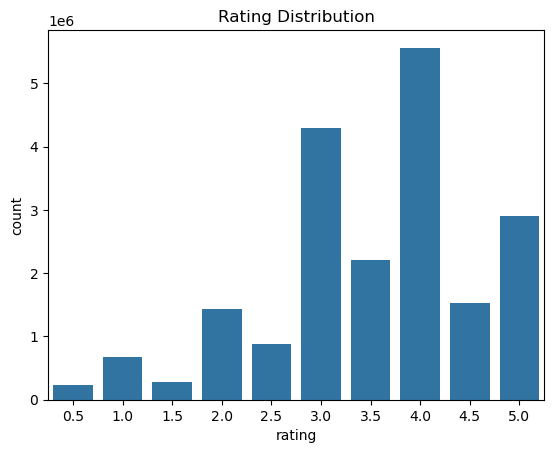

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='rating', data=ratings)
plt.title("Rating Distribution")
plt.show()

In [4]:
data = ratings.merge(movies, on="movieId")
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995),Adventure|Children|Fantasy
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


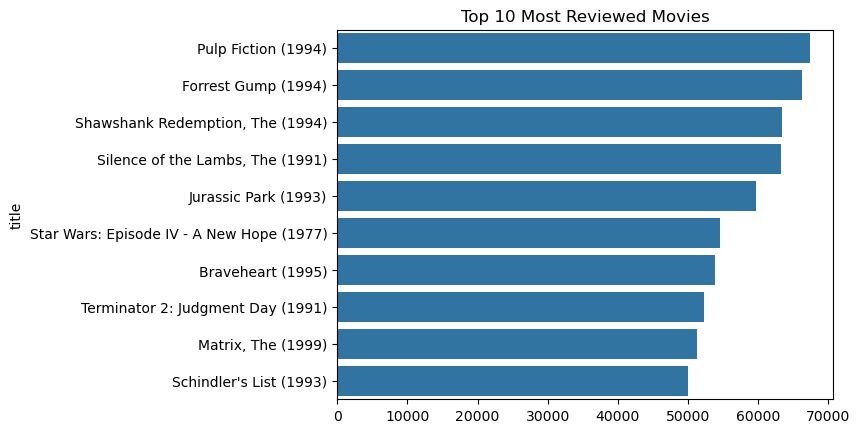

In [5]:
top_movies = data.groupby('title').size().sort_values(ascending=False)[:10]
sns.barplot(x=top_movies.values, y=top_movies.index)
plt.title("Top 10 Most Reviewed Movies")
plt.show()

In [6]:
movie_stats = data.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']

popular_movies = movie_stats[movie_stats['num_ratings'] >= 100]

highest_rated = popular_movies.sort_values('avg_rating', ascending=False)
highest_rated.head()

,avg_rating,num_ratings
title,,
"Shawshank Redemption, The (1994)",4.446990,63366
"Godfather, The (1972)",4.364732,41355
"Usual Suspects, The (1995)",4.334372,47006
Schindler's List (1993),4.310175,50054
"Godfather: Part II, The (1974)",4.275641,27398


In [7]:
# Check for missing values
print("Missing values in ratings:\n", ratings.isna().sum())
print("Missing values in movies:\n", movies.isna().sum())

# Check for duplicates
print("Duplicate rows in ratings:", ratings.duplicated().sum())
print("Duplicate rows in movies:", movies.duplicated().sum())

Missing values in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in movies:
 movieId    0
title      0
genres     0
dtype: int64
Duplicate rows in ratings: 0
Duplicate rows in movies: 0


In [8]:
# Calculate average rating of each film
movie_stats = data.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']
movie_stats.reset_index(inplace=True)
movie_stats.head()

,title,avg_rating,num_ratings
0,#chicagoGirl: The Social Network Takes on a Di...,3.666667,3
1,$ (Dollars) (1971),2.833333,24
2,$5 a Day (2008),2.871795,39
3,$9.99 (2008),3.009091,55
4,$ellebrity (Sellebrity) (2012),2.000000,2


In [9]:
# Exclude films with less than 500 reviews
popular_movies = movie_stats[movie_stats['num_ratings'] >= 500]['title']

# Filter ratings to include only these movies
subset_data = data[data['title'].isin(popular_movies)]

# Exclude reviews from people who rated less than 10 films
user_counts = subset_data['userId'].value_counts()
active_users = user_counts[user_counts >= 10].index
subset_data = subset_data[subset_data['userId'].isin(active_users)]

# Create pivot table
user_movie_matrix = subset_data.pivot_table(index='userId', columns='title', values='rating')
print(user_movie_matrix.shape)

(138482, 4489)


In [10]:
# Example: find movies similar to "Toy Story (1995)"
movie_ratings = user_movie_matrix['Toy Story (1995)']
similar_to_movie = user_movie_matrix.corrwith(movie_ratings)

# Drop NaNs
similar_to_movie = similar_to_movie.dropna()

# Convert to DataFrame
similar_movies = pd.DataFrame(similar_to_movie, columns=['correlation'])
similar_movies = similar_movies.join(
    movie_stats.set_index('title')['num_ratings'], how='inner'
)

# Keep only movies with enough ratings
recommendations = similar_movies[similar_movies['num_ratings'] >= 100].sort_values('correlation', ascending=False)

recommendations.head(10)

,correlation,num_ratings
title,,
Toy Story (1995),1.000000,49695
Toy Story 2 (1999),0.739854,22770
Toy Story 3 (2010),0.588510,5781
"Bug's Life, A (1998)",0.528696,20465
"Monsters, Inc. (2001)",0.520558,23657
Finding Nemo (2003),0.504607,23569
"Incredibles, The (2004)",0.440516,19890
Aladdin (1992),0.432785,41849
"Lion King, The (1994)",0.416696,38991


In [11]:
def recommend_films(movie_title, min_ratings=100, top_n=10):
    film_ratings = user_movie_matrix[movie_title]
    similar = user_movie_matrix.corrwith(film_ratings)
    similar = similar.dropna()
    df = pd.DataFrame(similar, columns=['correlation'])
    df = df.join(movie_stats.set_index('title')['num_ratings'])
    df = df[df['num_ratings'] >= min_ratings].sort_values('correlation', ascending=False)
    df = df.drop(movie_title, errors='ignore')
    return df.head(top_n)

# Example
recommend_films("Toy Story (1995)")

,correlation,num_ratings
title,,
Toy Story 2 (1999),0.739854,22770
Toy Story 3 (2010),0.588510,5781
"Bug's Life, A (1998)",0.528696,20465
"Monsters, Inc. (2001)",0.520558,23657
Finding Nemo (2003),0.504607,23569
"Incredibles, The (2004)",0.440516,19890
Aladdin (1992),0.432785,41849
"Lion King, The (1994)",0.416696,38991
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.414982,7784


In [12]:
film_stats = subset_data.groupby('title')['rating'].agg(['mean','count']).rename(columns={'count':'num_ratings','mean':'avg_rating'})

# Save data 
user_movie_matrix.to_pickle("../backend/model/user_film_matrix.pkl")
film_stats.to_pickle("../backend/model/film_stats.pkl")